In [15]:
import sys
sys.path.insert(1, '..')
import Utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kerastuner
print(tf.__version__)
print(kerastuner.__version__)
print(np.__version__)


2.3.0
1.0.2
1.19.5


In [16]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


In [17]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
    #    print(
    #        "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    #    )
        return

    def on_test_batch_end(self, batch, logs=None):
     #   print(
     #       "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
     #   )
        return

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and MSE is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_squared_logarithmic_error"]#logs["mean_squared_logarithmic_error"]
            )
        )


In [18]:
import pandas as pd

df = pd.read_excel ('/Volumes/data/LosAlamosSummer/Serializationstructures.xlsx')
print (df)
print(df.SFR)
SS=np.array(df.SFR[:-1])
print(SS)

            Sphere           LWR           SFR
0     2.615712e+02  1.000000e-03  1.000000e-03
1     5.737464e+02  6.865624e-03  6.865624e-03
2     8.888122e+02  9.160728e-03  9.160728e-03
3     1.195336e+03  1.107134e-02  1.107134e-02
4     1.481597e+03  1.273122e-02  1.273122e-02
...            ...           ...           ...
997   4.267269e+06  7.188363e+06  7.188363e+06
998   4.568146e+06  7.556836e+06  7.556836e+06
999   4.976225e+06  8.021766e+06  8.021766e+06
1000  5.607251e+06  8.701618e+06  8.701618e+06
1001  7.020693e+06           NaN           NaN

[1002 rows x 3 columns]
0       1.000000e-03
1       6.865624e-03
2       9.160728e-03
3       1.107134e-02
4       1.273122e-02
            ...     
997     7.188363e+06
998     7.556836e+06
999     8.021766e+06
1000    8.701618e+06
1001             NaN
Name: SFR, Length: 1002, dtype: float64
[1.00000000e-03 6.86562376e-03 9.16072825e-03 ... 7.55683605e+06
 8.02176620e+06 8.70161772e+06]


In [19]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/SFR/DATA/SFR_data_6.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=Utilities.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= Utilities.ProcessData(datapath, 1,1000,1,SS,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data


In [20]:
#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)

(41021,)
41021
(41021, 3)


In [21]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = Utilities.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 8204)
(3, 4102)
(41021, 3)
(3, 28713)


In [22]:

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (200, 0.0001),
    (400, 0.00001),
    (500, 0.000001),
    (600,0.0000001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [47]:
keff_model = tf.keras.Sequential([
    layers.Dense(22, activation='relu', name='hidden_1', input_dim=1000),
    layers.Dense(79, activation='relu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
keff_model.compile(loss="mean_squared_logarithmic_error",optimizer=tf.keras.optimizers.Adam(1e-03),metrics="mean_squared_logarithmic_error")
keff_model.build()
keff_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 22)                22022     
_________________________________________________________________
hidden_2 (Dense)             (None, 79)                1817      
_________________________________________________________________
output (Dense)               (None, 3)                 240       
Total params: 24,079
Trainable params: 24,079
Non-trainable params: 0
_________________________________________________________________


In [48]:
keff_model.fit(X_train,y_train.T, epochs=800, batch_size=44, verbose=1,
               shuffle=True,callbacks=[LossAndErrorPrintingCallback(),
        CustomLearningRateScheduler(lr_schedule)],validation_data=(X_val,y_val.T))


Epoch 00000: Learning rate is 0.0010.
Epoch 1/800
653/653 [==============================] - 1s 1ms/step - loss: 0.0309 - mean_squared_logarithmic_error: 0.0309 - val_loss: 0.0043 - val_mean_squared_logarithmic_error: 0.0043

Epoch 00001: Learning rate is 0.0010.
Epoch 2/800
653/653 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_logarithmic_error: 0.0022 - val_loss: 5.8728e-04 - val_mean_squared_logarithmic_error: 5.8728e-04

Epoch 00002: Learning rate is 0.0010.
Epoch 3/800
653/653 [==============================] - 1s 1ms/step - loss: 3.8502e-04 - mean_squared_logarithmic_error: 3.8502e-04 - val_loss: 2.6972e-04 - val_mean_squared_logarithmic_error: 2.6972e-04

Epoch 00003: Learning rate is 0.0010.
Epoch 4/800
653/653 [==============================] - 1s 999us/step - loss: 2.2031e-04 - mean_squared_logarithmic_error: 2.2031e-04 - val_loss: 2.8932e-04 - val_mean_squared_logarithmic_error: 2.8932e-04

Epoch 00004: Learning rate is 0.0010.
Epoch 5/800
653


Epoch 00020: Learning rate is 0.0010.
Epoch 21/800
653/653 [==============================] - 1s 917us/step - loss: 1.1002e-04 - mean_squared_logarithmic_error: 1.1002e-04 - val_loss: 1.2236e-04 - val_mean_squared_logarithmic_error: 1.2236e-04

Epoch 00021: Learning rate is 0.0010.
Epoch 22/800
653/653 [==============================] - 1s 969us/step - loss: 1.0625e-04 - mean_squared_logarithmic_error: 1.0625e-04 - val_loss: 1.1182e-04 - val_mean_squared_logarithmic_error: 1.1182e-04

Epoch 00022: Learning rate is 0.0010.
Epoch 23/800
653/653 [==============================] - 1s 1ms/step - loss: 1.0177e-04 - mean_squared_logarithmic_error: 1.0177e-04 - val_loss: 1.0691e-04 - val_mean_squared_logarithmic_error: 1.0691e-04

Epoch 00023: Learning rate is 0.0010.
Epoch 24/800
653/653 [==============================] - 1s 1ms/step - loss: 9.7563e-05 - mean_squared_logarithmic_error: 9.7563e-05 - val_loss: 1.1482e-04 - val_mean_squared_logarithmic_error: 1.1482e-04

Epoch 00024: Learning r


Epoch 00040: Learning rate is 0.0010.
Epoch 41/800
653/653 [==============================] - 1s 877us/step - loss: 6.6746e-05 - mean_squared_logarithmic_error: 6.6746e-05 - val_loss: 1.2344e-04 - val_mean_squared_logarithmic_error: 1.2344e-04

Epoch 00041: Learning rate is 0.0010.
Epoch 42/800
653/653 [==============================] - 1s 868us/step - loss: 6.5279e-05 - mean_squared_logarithmic_error: 6.5279e-05 - val_loss: 1.2922e-04 - val_mean_squared_logarithmic_error: 1.2922e-04

Epoch 00042: Learning rate is 0.0010.
Epoch 43/800
653/653 [==============================] - 1s 882us/step - loss: 6.5318e-05 - mean_squared_logarithmic_error: 6.5318e-05 - val_loss: 1.1291e-04 - val_mean_squared_logarithmic_error: 1.1291e-04

Epoch 00043: Learning rate is 0.0010.
Epoch 44/800
653/653 [==============================] - 1s 893us/step - loss: 6.4104e-05 - mean_squared_logarithmic_error: 6.4104e-05 - val_loss: 1.1401e-04 - val_mean_squared_logarithmic_error: 1.1401e-04

Epoch 00044: Learni


Epoch 00060: Learning rate is 0.0010.
Epoch 61/800
653/653 [==============================] - 1s 863us/step - loss: 5.2736e-05 - mean_squared_logarithmic_error: 5.2736e-05 - val_loss: 1.2273e-04 - val_mean_squared_logarithmic_error: 1.2273e-04

Epoch 00061: Learning rate is 0.0010.
Epoch 62/800
653/653 [==============================] - 1s 879us/step - loss: 5.2448e-05 - mean_squared_logarithmic_error: 5.2448e-05 - val_loss: 1.1595e-04 - val_mean_squared_logarithmic_error: 1.1595e-04

Epoch 00062: Learning rate is 0.0010.
Epoch 63/800
653/653 [==============================] - 1s 873us/step - loss: 5.2272e-05 - mean_squared_logarithmic_error: 5.2272e-05 - val_loss: 1.3291e-04 - val_mean_squared_logarithmic_error: 1.3291e-04

Epoch 00063: Learning rate is 0.0010.
Epoch 64/800
653/653 [==============================] - 1s 896us/step - loss: 5.0853e-05 - mean_squared_logarithmic_error: 5.0853e-05 - val_loss: 1.3324e-04 - val_mean_squared_logarithmic_error: 1.3324e-04

Epoch 00064: Learni


Epoch 00080: Learning rate is 0.0010.
Epoch 81/800
653/653 [==============================] - 1s 885us/step - loss: 4.6510e-05 - mean_squared_logarithmic_error: 4.6510e-05 - val_loss: 1.3384e-04 - val_mean_squared_logarithmic_error: 1.3384e-04

Epoch 00081: Learning rate is 0.0010.
Epoch 82/800
653/653 [==============================] - 1s 874us/step - loss: 4.8653e-05 - mean_squared_logarithmic_error: 4.8653e-05 - val_loss: 1.1907e-04 - val_mean_squared_logarithmic_error: 1.1907e-04

Epoch 00082: Learning rate is 0.0010.
Epoch 83/800
653/653 [==============================] - 1s 876us/step - loss: 4.7123e-05 - mean_squared_logarithmic_error: 4.7123e-05 - val_loss: 1.1868e-04 - val_mean_squared_logarithmic_error: 1.1868e-04

Epoch 00083: Learning rate is 0.0010.
Epoch 84/800
653/653 [==============================] - 1s 870us/step - loss: 4.6452e-05 - mean_squared_logarithmic_error: 4.6452e-05 - val_loss: 1.1856e-04 - val_mean_squared_logarithmic_error: 1.1856e-04

Epoch 00084: Learni

653/653 [==============================] - 1s 874us/step - loss: 4.3629e-05 - mean_squared_logarithmic_error: 4.3629e-05 - val_loss: 1.1414e-04 - val_mean_squared_logarithmic_error: 1.1414e-04

Epoch 00100: Learning rate is 0.0010.
Epoch 101/800
653/653 [==============================] - 1s 873us/step - loss: 4.3671e-05 - mean_squared_logarithmic_error: 4.3671e-05 - val_loss: 1.2031e-04 - val_mean_squared_logarithmic_error: 1.2031e-04

Epoch 00101: Learning rate is 0.0010.
Epoch 102/800
653/653 [==============================] - 1s 869us/step - loss: 4.3630e-05 - mean_squared_logarithmic_error: 4.3630e-05 - val_loss: 1.2459e-04 - val_mean_squared_logarithmic_error: 1.2459e-04

Epoch 00102: Learning rate is 0.0010.
Epoch 103/800
653/653 [==============================] - 1s 860us/step - loss: 4.4158e-05 - mean_squared_logarithmic_error: 4.4158e-05 - val_loss: 1.2162e-04 - val_mean_squared_logarithmic_error: 1.2162e-04

Epoch 00103: Learning rate is 0.0010.
Epoch 104/800
653/653 [=======


Epoch 00119: Learning rate is 0.0010.
Epoch 120/800
653/653 [==============================] - 1s 887us/step - loss: 4.1473e-05 - mean_squared_logarithmic_error: 4.1473e-05 - val_loss: 1.1960e-04 - val_mean_squared_logarithmic_error: 1.1960e-04

Epoch 00120: Learning rate is 0.0010.
Epoch 121/800
653/653 [==============================] - 1s 929us/step - loss: 4.1618e-05 - mean_squared_logarithmic_error: 4.1618e-05 - val_loss: 1.1958e-04 - val_mean_squared_logarithmic_error: 1.1958e-04

Epoch 00121: Learning rate is 0.0010.
Epoch 122/800
653/653 [==============================] - 1s 908us/step - loss: 4.2200e-05 - mean_squared_logarithmic_error: 4.2200e-05 - val_loss: 1.1985e-04 - val_mean_squared_logarithmic_error: 1.1985e-04

Epoch 00122: Learning rate is 0.0010.
Epoch 123/800
653/653 [==============================] - 1s 879us/step - loss: 4.2770e-05 - mean_squared_logarithmic_error: 4.2770e-05 - val_loss: 1.1610e-04 - val_mean_squared_logarithmic_error: 1.1610e-04

Epoch 00123: Le


Epoch 00139: Learning rate is 0.0010.
Epoch 140/800
653/653 [==============================] - 1s 869us/step - loss: 4.0792e-05 - mean_squared_logarithmic_error: 4.0792e-05 - val_loss: 1.1535e-04 - val_mean_squared_logarithmic_error: 1.1535e-04

Epoch 00140: Learning rate is 0.0010.
Epoch 141/800
653/653 [==============================] - 1s 876us/step - loss: 3.9415e-05 - mean_squared_logarithmic_error: 3.9415e-05 - val_loss: 1.2560e-04 - val_mean_squared_logarithmic_error: 1.2560e-04

Epoch 00141: Learning rate is 0.0010.
Epoch 142/800
653/653 [==============================] - 1s 912us/step - loss: 3.9950e-05 - mean_squared_logarithmic_error: 3.9950e-05 - val_loss: 1.1808e-04 - val_mean_squared_logarithmic_error: 1.1808e-04

Epoch 00142: Learning rate is 0.0010.
Epoch 143/800
653/653 [==============================] - 1s 876us/step - loss: 3.9288e-05 - mean_squared_logarithmic_error: 3.9288e-05 - val_loss: 1.1782e-04 - val_mean_squared_logarithmic_error: 1.1782e-04

Epoch 00143: Le


Epoch 00159: Learning rate is 0.0010.
Epoch 160/800
653/653 [==============================] - 1s 877us/step - loss: 3.8189e-05 - mean_squared_logarithmic_error: 3.8189e-05 - val_loss: 1.1905e-04 - val_mean_squared_logarithmic_error: 1.1905e-04

Epoch 00160: Learning rate is 0.0010.
Epoch 161/800
653/653 [==============================] - 1s 871us/step - loss: 3.8646e-05 - mean_squared_logarithmic_error: 3.8646e-05 - val_loss: 1.1539e-04 - val_mean_squared_logarithmic_error: 1.1539e-04

Epoch 00161: Learning rate is 0.0010.
Epoch 162/800
653/653 [==============================] - 1s 878us/step - loss: 3.8318e-05 - mean_squared_logarithmic_error: 3.8318e-05 - val_loss: 1.1680e-04 - val_mean_squared_logarithmic_error: 1.1680e-04

Epoch 00162: Learning rate is 0.0010.
Epoch 163/800
653/653 [==============================] - 1s 869us/step - loss: 3.7532e-05 - mean_squared_logarithmic_error: 3.7532e-05 - val_loss: 1.2022e-04 - val_mean_squared_logarithmic_error: 1.2022e-04

Epoch 00163: Le


Epoch 00179: Learning rate is 0.0010.
Epoch 180/800
653/653 [==============================] - 1s 872us/step - loss: 3.7631e-05 - mean_squared_logarithmic_error: 3.7631e-05 - val_loss: 1.1905e-04 - val_mean_squared_logarithmic_error: 1.1905e-04

Epoch 00180: Learning rate is 0.0010.
Epoch 181/800
653/653 [==============================] - 1s 879us/step - loss: 3.7743e-05 - mean_squared_logarithmic_error: 3.7743e-05 - val_loss: 1.1728e-04 - val_mean_squared_logarithmic_error: 1.1728e-04

Epoch 00181: Learning rate is 0.0010.
Epoch 182/800
653/653 [==============================] - 1s 1ms/step - loss: 3.7330e-05 - mean_squared_logarithmic_error: 3.7330e-05 - val_loss: 1.1939e-04 - val_mean_squared_logarithmic_error: 1.1939e-04

Epoch 00182: Learning rate is 0.0010.
Epoch 183/800
653/653 [==============================] - 1s 1ms/step - loss: 3.6316e-05 - mean_squared_logarithmic_error: 3.6316e-05 - val_loss: 1.2122e-04 - val_mean_squared_logarithmic_error: 1.2122e-04

Epoch 00183: Learni


Epoch 00199: Learning rate is 0.0010.
Epoch 200/800
653/653 [==============================] - 1s 880us/step - loss: 3.5641e-05 - mean_squared_logarithmic_error: 3.5641e-05 - val_loss: 1.2497e-04 - val_mean_squared_logarithmic_error: 1.2497e-04

Epoch 00200: Learning rate is 0.0001.
Epoch 201/800
653/653 [==============================] - 1s 869us/step - loss: 2.9840e-05 - mean_squared_logarithmic_error: 2.9840e-05 - val_loss: 1.1375e-04 - val_mean_squared_logarithmic_error: 1.1375e-04

Epoch 00201: Learning rate is 0.0001.
Epoch 202/800
653/653 [==============================] - 1s 883us/step - loss: 2.8433e-05 - mean_squared_logarithmic_error: 2.8433e-05 - val_loss: 1.1550e-04 - val_mean_squared_logarithmic_error: 1.1550e-04

Epoch 00202: Learning rate is 0.0001.
Epoch 203/800
653/653 [==============================] - 1s 878us/step - loss: 2.8033e-05 - mean_squared_logarithmic_error: 2.8033e-05 - val_loss: 1.1405e-04 - val_mean_squared_logarithmic_error: 1.1405e-04

Epoch 00203: Le


Epoch 00219: Learning rate is 0.0001.
Epoch 220/800
653/653 [==============================] - 1s 910us/step - loss: 2.6496e-05 - mean_squared_logarithmic_error: 2.6496e-05 - val_loss: 1.1880e-04 - val_mean_squared_logarithmic_error: 1.1880e-04

Epoch 00220: Learning rate is 0.0001.
Epoch 221/800
653/653 [==============================] - 1s 873us/step - loss: 2.6337e-05 - mean_squared_logarithmic_error: 2.6337e-05 - val_loss: 1.1945e-04 - val_mean_squared_logarithmic_error: 1.1945e-04

Epoch 00221: Learning rate is 0.0001.
Epoch 222/800
653/653 [==============================] - 1s 904us/step - loss: 2.6433e-05 - mean_squared_logarithmic_error: 2.6433e-05 - val_loss: 1.1921e-04 - val_mean_squared_logarithmic_error: 1.1921e-04

Epoch 00222: Learning rate is 0.0001.
Epoch 223/800
653/653 [==============================] - 1s 911us/step - loss: 2.6391e-05 - mean_squared_logarithmic_error: 2.6391e-05 - val_loss: 1.2048e-04 - val_mean_squared_logarithmic_error: 1.2048e-04

Epoch 00223: Le


Epoch 00239: Learning rate is 0.0001.
Epoch 240/800
653/653 [==============================] - 1s 876us/step - loss: 2.6002e-05 - mean_squared_logarithmic_error: 2.6002e-05 - val_loss: 1.2176e-04 - val_mean_squared_logarithmic_error: 1.2176e-04

Epoch 00240: Learning rate is 0.0001.
Epoch 241/800
653/653 [==============================] - 1s 892us/step - loss: 2.6008e-05 - mean_squared_logarithmic_error: 2.6008e-05 - val_loss: 1.2084e-04 - val_mean_squared_logarithmic_error: 1.2084e-04

Epoch 00241: Learning rate is 0.0001.
Epoch 242/800
653/653 [==============================] - 1s 879us/step - loss: 2.5952e-05 - mean_squared_logarithmic_error: 2.5952e-05 - val_loss: 1.2216e-04 - val_mean_squared_logarithmic_error: 1.2216e-04

Epoch 00242: Learning rate is 0.0001.
Epoch 243/800
653/653 [==============================] - 1s 875us/step - loss: 2.6006e-05 - mean_squared_logarithmic_error: 2.6006e-05 - val_loss: 1.2102e-04 - val_mean_squared_logarithmic_error: 1.2102e-04

Epoch 00243: Le


Epoch 00259: Learning rate is 0.0001.
Epoch 260/800
653/653 [==============================] - 1s 871us/step - loss: 2.5730e-05 - mean_squared_logarithmic_error: 2.5730e-05 - val_loss: 1.2239e-04 - val_mean_squared_logarithmic_error: 1.2239e-04

Epoch 00260: Learning rate is 0.0001.
Epoch 261/800
653/653 [==============================] - 1s 879us/step - loss: 2.5786e-05 - mean_squared_logarithmic_error: 2.5786e-05 - val_loss: 1.2201e-04 - val_mean_squared_logarithmic_error: 1.2201e-04

Epoch 00261: Learning rate is 0.0001.
Epoch 262/800
653/653 [==============================] - 1s 882us/step - loss: 2.5767e-05 - mean_squared_logarithmic_error: 2.5767e-05 - val_loss: 1.2246e-04 - val_mean_squared_logarithmic_error: 1.2246e-04

Epoch 00262: Learning rate is 0.0001.
Epoch 263/800
653/653 [==============================] - 1s 891us/step - loss: 2.5751e-05 - mean_squared_logarithmic_error: 2.5751e-05 - val_loss: 1.2265e-04 - val_mean_squared_logarithmic_error: 1.2265e-04

Epoch 00263: Le


Epoch 00279: Learning rate is 0.0001.
Epoch 280/800
653/653 [==============================] - 1s 867us/step - loss: 2.5625e-05 - mean_squared_logarithmic_error: 2.5625e-05 - val_loss: 1.2427e-04 - val_mean_squared_logarithmic_error: 1.2427e-04

Epoch 00280: Learning rate is 0.0001.
Epoch 281/800
653/653 [==============================] - 1s 867us/step - loss: 2.5560e-05 - mean_squared_logarithmic_error: 2.5560e-05 - val_loss: 1.2476e-04 - val_mean_squared_logarithmic_error: 1.2476e-04

Epoch 00281: Learning rate is 0.0001.
Epoch 282/800
653/653 [==============================] - 1s 869us/step - loss: 2.5640e-05 - mean_squared_logarithmic_error: 2.5640e-05 - val_loss: 1.2514e-04 - val_mean_squared_logarithmic_error: 1.2514e-04

Epoch 00282: Learning rate is 0.0001.
Epoch 283/800
653/653 [==============================] - 1s 939us/step - loss: 2.5561e-05 - mean_squared_logarithmic_error: 2.5561e-05 - val_loss: 1.2471e-04 - val_mean_squared_logarithmic_error: 1.2471e-04

Epoch 00283: Le


Epoch 00299: Learning rate is 0.0001.
Epoch 300/800
653/653 [==============================] - 1s 881us/step - loss: 2.5409e-05 - mean_squared_logarithmic_error: 2.5409e-05 - val_loss: 1.2627e-04 - val_mean_squared_logarithmic_error: 1.2627e-04

Epoch 00300: Learning rate is 0.0001.
Epoch 301/800
653/653 [==============================] - 1s 882us/step - loss: 2.5440e-05 - mean_squared_logarithmic_error: 2.5440e-05 - val_loss: 1.2477e-04 - val_mean_squared_logarithmic_error: 1.2477e-04

Epoch 00301: Learning rate is 0.0001.
Epoch 302/800
653/653 [==============================] - 1s 893us/step - loss: 2.5507e-05 - mean_squared_logarithmic_error: 2.5507e-05 - val_loss: 1.2529e-04 - val_mean_squared_logarithmic_error: 1.2529e-04

Epoch 00302: Learning rate is 0.0001.
Epoch 303/800
653/653 [==============================] - 1s 887us/step - loss: 2.5380e-05 - mean_squared_logarithmic_error: 2.5380e-05 - val_loss: 1.2540e-04 - val_mean_squared_logarithmic_error: 1.2540e-04

Epoch 00303: Le


Epoch 00319: Learning rate is 0.0001.
Epoch 320/800
653/653 [==============================] - 1s 872us/step - loss: 2.5248e-05 - mean_squared_logarithmic_error: 2.5248e-05 - val_loss: 1.2632e-04 - val_mean_squared_logarithmic_error: 1.2632e-04

Epoch 00320: Learning rate is 0.0001.
Epoch 321/800
653/653 [==============================] - 1s 874us/step - loss: 2.5326e-05 - mean_squared_logarithmic_error: 2.5326e-05 - val_loss: 1.2609e-04 - val_mean_squared_logarithmic_error: 1.2609e-04

Epoch 00321: Learning rate is 0.0001.
Epoch 322/800
653/653 [==============================] - 1s 874us/step - loss: 2.5265e-05 - mean_squared_logarithmic_error: 2.5265e-05 - val_loss: 1.2693e-04 - val_mean_squared_logarithmic_error: 1.2693e-04

Epoch 00322: Learning rate is 0.0001.
Epoch 323/800
653/653 [==============================] - 1s 880us/step - loss: 2.5283e-05 - mean_squared_logarithmic_error: 2.5283e-05 - val_loss: 1.2742e-04 - val_mean_squared_logarithmic_error: 1.2742e-04

Epoch 00323: Le


Epoch 00339: Learning rate is 0.0001.
Epoch 340/800
653/653 [==============================] - 1s 877us/step - loss: 2.5224e-05 - mean_squared_logarithmic_error: 2.5224e-05 - val_loss: 1.2758e-04 - val_mean_squared_logarithmic_error: 1.2758e-04

Epoch 00340: Learning rate is 0.0001.
Epoch 341/800
653/653 [==============================] - 1s 871us/step - loss: 2.5176e-05 - mean_squared_logarithmic_error: 2.5176e-05 - val_loss: 1.2684e-04 - val_mean_squared_logarithmic_error: 1.2684e-04

Epoch 00341: Learning rate is 0.0001.
Epoch 342/800
653/653 [==============================] - 1s 877us/step - loss: 2.5234e-05 - mean_squared_logarithmic_error: 2.5234e-05 - val_loss: 1.2825e-04 - val_mean_squared_logarithmic_error: 1.2825e-04

Epoch 00342: Learning rate is 0.0001.
Epoch 343/800
653/653 [==============================] - 1s 871us/step - loss: 2.5214e-05 - mean_squared_logarithmic_error: 2.5214e-05 - val_loss: 1.2793e-04 - val_mean_squared_logarithmic_error: 1.2793e-04

Epoch 00343: Le


Epoch 00359: Learning rate is 0.0001.
Epoch 360/800
653/653 [==============================] - 1s 937us/step - loss: 2.5072e-05 - mean_squared_logarithmic_error: 2.5072e-05 - val_loss: 1.2738e-04 - val_mean_squared_logarithmic_error: 1.2738e-04

Epoch 00360: Learning rate is 0.0001.
Epoch 361/800
653/653 [==============================] - 1s 955us/step - loss: 2.5050e-05 - mean_squared_logarithmic_error: 2.5050e-05 - val_loss: 1.2958e-04 - val_mean_squared_logarithmic_error: 1.2958e-04

Epoch 00361: Learning rate is 0.0001.
Epoch 362/800
653/653 [==============================] - 1s 940us/step - loss: 2.5072e-05 - mean_squared_logarithmic_error: 2.5072e-05 - val_loss: 1.2806e-04 - val_mean_squared_logarithmic_error: 1.2806e-04

Epoch 00362: Learning rate is 0.0001.
Epoch 363/800
653/653 [==============================] - 1s 954us/step - loss: 2.5092e-05 - mean_squared_logarithmic_error: 2.5092e-05 - val_loss: 1.2918e-04 - val_mean_squared_logarithmic_error: 1.2918e-04

Epoch 00363: Le


Epoch 00379: Learning rate is 0.0001.
Epoch 380/800
653/653 [==============================] - 1s 970us/step - loss: 2.5024e-05 - mean_squared_logarithmic_error: 2.5024e-05 - val_loss: 1.2974e-04 - val_mean_squared_logarithmic_error: 1.2974e-04

Epoch 00380: Learning rate is 0.0001.
Epoch 381/800
653/653 [==============================] - 1s 972us/step - loss: 2.5046e-05 - mean_squared_logarithmic_error: 2.5046e-05 - val_loss: 1.2898e-04 - val_mean_squared_logarithmic_error: 1.2898e-04

Epoch 00381: Learning rate is 0.0001.
Epoch 382/800
653/653 [==============================] - 1s 970us/step - loss: 2.4957e-05 - mean_squared_logarithmic_error: 2.4957e-05 - val_loss: 1.3005e-04 - val_mean_squared_logarithmic_error: 1.3005e-04

Epoch 00382: Learning rate is 0.0001.
Epoch 383/800
653/653 [==============================] - 1s 972us/step - loss: 2.5040e-05 - mean_squared_logarithmic_error: 2.5040e-05 - val_loss: 1.2857e-04 - val_mean_squared_logarithmic_error: 1.2857e-04

Epoch 00383: Le


Epoch 00399: Learning rate is 0.0001.
Epoch 400/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4927e-05 - mean_squared_logarithmic_error: 2.4927e-05 - val_loss: 1.3000e-04 - val_mean_squared_logarithmic_error: 1.3000e-04

Epoch 00400: Learning rate is 0.0000.
Epoch 401/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4274e-05 - mean_squared_logarithmic_error: 2.4274e-05 - val_loss: 1.2961e-04 - val_mean_squared_logarithmic_error: 1.2961e-04

Epoch 00401: Learning rate is 0.0000.
Epoch 402/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4192e-05 - mean_squared_logarithmic_error: 2.4192e-05 - val_loss: 1.2945e-04 - val_mean_squared_logarithmic_error: 1.2945e-04

Epoch 00402: Learning rate is 0.0000.
Epoch 403/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4184e-05 - mean_squared_logarithmic_error: 2.4184e-05 - val_loss: 1.2940e-04 - val_mean_squared_logarithmic_error: 1.2940e-04

Epoch 00403: Learning r


Epoch 00419: Learning rate is 0.0000.
Epoch 420/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4131e-05 - mean_squared_logarithmic_error: 2.4131e-05 - val_loss: 1.2948e-04 - val_mean_squared_logarithmic_error: 1.2948e-04

Epoch 00420: Learning rate is 0.0000.
Epoch 421/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4123e-05 - mean_squared_logarithmic_error: 2.4123e-05 - val_loss: 1.2940e-04 - val_mean_squared_logarithmic_error: 1.2940e-04

Epoch 00421: Learning rate is 0.0000.
Epoch 422/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4124e-05 - mean_squared_logarithmic_error: 2.4124e-05 - val_loss: 1.2947e-04 - val_mean_squared_logarithmic_error: 1.2947e-04

Epoch 00422: Learning rate is 0.0000.
Epoch 423/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4117e-05 - mean_squared_logarithmic_error: 2.4117e-05 - val_loss: 1.2949e-04 - val_mean_squared_logarithmic_error: 1.2949e-04

Epoch 00423: Learning r


Epoch 00439: Learning rate is 0.0000.
Epoch 440/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4102e-05 - mean_squared_logarithmic_error: 2.4102e-05 - val_loss: 1.2943e-04 - val_mean_squared_logarithmic_error: 1.2943e-04

Epoch 00440: Learning rate is 0.0000.
Epoch 441/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4105e-05 - mean_squared_logarithmic_error: 2.4105e-05 - val_loss: 1.2943e-04 - val_mean_squared_logarithmic_error: 1.2943e-04

Epoch 00441: Learning rate is 0.0000.
Epoch 442/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4104e-05 - mean_squared_logarithmic_error: 2.4104e-05 - val_loss: 1.2957e-04 - val_mean_squared_logarithmic_error: 1.2957e-04

Epoch 00442: Learning rate is 0.0000.
Epoch 443/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4103e-05 - mean_squared_logarithmic_error: 2.4103e-05 - val_loss: 1.2951e-04 - val_mean_squared_logarithmic_error: 1.2951e-04

Epoch 00443: Learning r


Epoch 00459: Learning rate is 0.0000.
Epoch 460/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4105e-05 - mean_squared_logarithmic_error: 2.4105e-05 - val_loss: 1.2945e-04 - val_mean_squared_logarithmic_error: 1.2945e-04

Epoch 00460: Learning rate is 0.0000.
Epoch 461/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4104e-05 - mean_squared_logarithmic_error: 2.4104e-05 - val_loss: 1.2962e-04 - val_mean_squared_logarithmic_error: 1.2962e-04

Epoch 00461: Learning rate is 0.0000.
Epoch 462/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4084e-05 - mean_squared_logarithmic_error: 2.4084e-05 - val_loss: 1.2966e-04 - val_mean_squared_logarithmic_error: 1.2966e-04

Epoch 00462: Learning rate is 0.0000.
Epoch 463/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4099e-05 - mean_squared_logarithmic_error: 2.4099e-05 - val_loss: 1.2961e-04 - val_mean_squared_logarithmic_error: 1.2961e-04

Epoch 00463: Learning r

653/653 [==============================] - 1s 1ms/step - loss: 2.4087e-05 - mean_squared_logarithmic_error: 2.4087e-05 - val_loss: 1.2962e-04 - val_mean_squared_logarithmic_error: 1.2962e-04

Epoch 00479: Learning rate is 0.0000.
Epoch 480/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4081e-05 - mean_squared_logarithmic_error: 2.4081e-05 - val_loss: 1.2961e-04 - val_mean_squared_logarithmic_error: 1.2961e-04

Epoch 00480: Learning rate is 0.0000.
Epoch 481/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4088e-05 - mean_squared_logarithmic_error: 2.4088e-05 - val_loss: 1.2961e-04 - val_mean_squared_logarithmic_error: 1.2961e-04

Epoch 00481: Learning rate is 0.0000.
Epoch 482/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4086e-05 - mean_squared_logarithmic_error: 2.4086e-05 - val_loss: 1.2962e-04 - val_mean_squared_logarithmic_error: 1.2962e-04

Epoch 00482: Learning rate is 0.0000.
Epoch 483/800
653/653 [===============


Epoch 00498: Learning rate is 0.0000.
Epoch 499/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4094e-05 - mean_squared_logarithmic_error: 2.4094e-05 - val_loss: 1.2985e-04 - val_mean_squared_logarithmic_error: 1.2985e-04

Epoch 00499: Learning rate is 0.0000.
Epoch 500/800
653/653 [==============================] - 1s 1ms/step - loss: 2.4082e-05 - mean_squared_logarithmic_error: 2.4082e-05 - val_loss: 1.2969e-04 - val_mean_squared_logarithmic_error: 1.2969e-04

Epoch 00500: Learning rate is 0.0000.
Epoch 501/800
653/653 [==============================] - 1s 1000us/step - loss: 2.4001e-05 - mean_squared_logarithmic_error: 2.4001e-05 - val_loss: 1.2967e-04 - val_mean_squared_logarithmic_error: 1.2967e-04

Epoch 00501: Learning rate is 0.0000.
Epoch 502/800
653/653 [==============================] - 1s 1ms/step - loss: 2.3995e-05 - mean_squared_logarithmic_error: 2.3995e-05 - val_loss: 1.2969e-04 - val_mean_squared_logarithmic_error: 1.2969e-04

Epoch 00502: Learnin


Epoch 00518: Learning rate is 0.0000.
Epoch 519/800
653/653 [==============================] - 1s 995us/step - loss: 2.3988e-05 - mean_squared_logarithmic_error: 2.3988e-05 - val_loss: 1.2974e-04 - val_mean_squared_logarithmic_error: 1.2974e-04

Epoch 00519: Learning rate is 0.0000.
Epoch 520/800
653/653 [==============================] - 1s 980us/step - loss: 2.3988e-05 - mean_squared_logarithmic_error: 2.3988e-05 - val_loss: 1.2973e-04 - val_mean_squared_logarithmic_error: 1.2973e-04

Epoch 00520: Learning rate is 0.0000.
Epoch 521/800
653/653 [==============================] - 1s 967us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00521: Learning rate is 0.0000.
Epoch 522/800
653/653 [==============================] - 1s 969us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2972e-04 - val_mean_squared_logarithmic_error: 1.2972e-04

Epoch 00522: Le


Epoch 00538: Learning rate is 0.0000.
Epoch 539/800
653/653 [==============================] - 1s 967us/step - loss: 2.3988e-05 - mean_squared_logarithmic_error: 2.3988e-05 - val_loss: 1.2974e-04 - val_mean_squared_logarithmic_error: 1.2974e-04

Epoch 00539: Learning rate is 0.0000.
Epoch 540/800
653/653 [==============================] - 1s 967us/step - loss: 2.3987e-05 - mean_squared_logarithmic_error: 2.3987e-05 - val_loss: 1.2973e-04 - val_mean_squared_logarithmic_error: 1.2973e-04

Epoch 00540: Learning rate is 0.0000.
Epoch 541/800
653/653 [==============================] - 1s 970us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2974e-04 - val_mean_squared_logarithmic_error: 1.2974e-04

Epoch 00541: Learning rate is 0.0000.
Epoch 542/800
653/653 [==============================] - 1s 966us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2973e-04 - val_mean_squared_logarithmic_error: 1.2973e-04

Epoch 00542: Le

653/653 [==============================] - 1s 976us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00558: Learning rate is 0.0000.
Epoch 559/800
653/653 [==============================] - 1s 958us/step - loss: 2.3986e-05 - mean_squared_logarithmic_error: 2.3986e-05 - val_loss: 1.2973e-04 - val_mean_squared_logarithmic_error: 1.2973e-04

Epoch 00559: Learning rate is 0.0000.
Epoch 560/800
653/653 [==============================] - 1s 945us/step - loss: 2.3987e-05 - mean_squared_logarithmic_error: 2.3987e-05 - val_loss: 1.2974e-04 - val_mean_squared_logarithmic_error: 1.2974e-04

Epoch 00560: Learning rate is 0.0000.
Epoch 561/800
653/653 [==============================] - 1s 960us/step - loss: 2.3985e-05 - mean_squared_logarithmic_error: 2.3985e-05 - val_loss: 1.2973e-04 - val_mean_squared_logarithmic_error: 1.2973e-04

Epoch 00561: Learning rate is 0.0000.
Epoch 562/800
653/653 [=======


Epoch 00577: Learning rate is 0.0000.
Epoch 578/800
653/653 [==============================] - 1s 938us/step - loss: 2.3984e-05 - mean_squared_logarithmic_error: 2.3984e-05 - val_loss: 1.2976e-04 - val_mean_squared_logarithmic_error: 1.2976e-04

Epoch 00578: Learning rate is 0.0000.
Epoch 579/800
653/653 [==============================] - 1s 960us/step - loss: 2.3983e-05 - mean_squared_logarithmic_error: 2.3983e-05 - val_loss: 1.2975e-04 - val_mean_squared_logarithmic_error: 1.2975e-04

Epoch 00579: Learning rate is 0.0000.
Epoch 580/800
653/653 [==============================] - 1s 930us/step - loss: 2.3983e-05 - mean_squared_logarithmic_error: 2.3983e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00580: Learning rate is 0.0000.
Epoch 581/800
653/653 [==============================] - 1s 934us/step - loss: 2.3983e-05 - mean_squared_logarithmic_error: 2.3983e-05 - val_loss: 1.2976e-04 - val_mean_squared_logarithmic_error: 1.2976e-04

Epoch 00581: Le


Epoch 00597: Learning rate is 0.0000.
Epoch 598/800
653/653 [==============================] - 1s 945us/step - loss: 2.3984e-05 - mean_squared_logarithmic_error: 2.3984e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00598: Learning rate is 0.0000.
Epoch 599/800
653/653 [==============================] - 1s 940us/step - loss: 2.3984e-05 - mean_squared_logarithmic_error: 2.3984e-05 - val_loss: 1.2976e-04 - val_mean_squared_logarithmic_error: 1.2976e-04

Epoch 00599: Learning rate is 0.0000.
Epoch 600/800
653/653 [==============================] - 1s 945us/step - loss: 2.3984e-05 - mean_squared_logarithmic_error: 2.3984e-05 - val_loss: 1.2976e-04 - val_mean_squared_logarithmic_error: 1.2976e-04

Epoch 00600: Learning rate is 0.0000.
Epoch 601/800
653/653 [==============================] - 1s 1ms/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2976e-04 - val_mean_squared_logarithmic_error: 1.2976e-04

Epoch 00601: Lear


Epoch 00617: Learning rate is 0.0000.
Epoch 618/800
653/653 [==============================] - 1s 936us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00618: Learning rate is 0.0000.
Epoch 619/800
653/653 [==============================] - 1s 937us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00619: Learning rate is 0.0000.
Epoch 620/800
653/653 [==============================] - 1s 930us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00620: Learning rate is 0.0000.
Epoch 621/800
653/653 [==============================] - 1s 940us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00621: Le


Epoch 00637: Learning rate is 0.0000.
Epoch 638/800
653/653 [==============================] - 1s 937us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00638: Learning rate is 0.0000.
Epoch 639/800
653/653 [==============================] - 1s 944us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00639: Learning rate is 0.0000.
Epoch 640/800
653/653 [==============================] - 1s 933us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00640: Learning rate is 0.0000.
Epoch 641/800
653/653 [==============================] - 1s 935us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00641: Le


Epoch 00657: Learning rate is 0.0000.
Epoch 658/800
653/653 [==============================] - 1s 934us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00658: Learning rate is 0.0000.
Epoch 659/800
653/653 [==============================] - 1s 934us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00659: Learning rate is 0.0000.
Epoch 660/800
653/653 [==============================] - 1s 936us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00660: Learning rate is 0.0000.
Epoch 661/800
653/653 [==============================] - 1s 930us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00661: Le


Epoch 00677: Learning rate is 0.0000.
Epoch 678/800
653/653 [==============================] - 1s 950us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00678: Learning rate is 0.0000.
Epoch 679/800
653/653 [==============================] - 1s 934us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00679: Learning rate is 0.0000.
Epoch 680/800
653/653 [==============================] - 1s 934us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2977e-04 - val_mean_squared_logarithmic_error: 1.2977e-04

Epoch 00680: Learning rate is 0.0000.
Epoch 681/800
653/653 [==============================] - 1s 933us/step - loss: 2.3973e-05 - mean_squared_logarithmic_error: 2.3973e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00681: Le


Epoch 00697: Learning rate is 0.0000.
Epoch 698/800
653/653 [==============================] - 1s 935us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00698: Learning rate is 0.0000.
Epoch 699/800
653/653 [==============================] - 1s 928us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00699: Learning rate is 0.0000.
Epoch 700/800
653/653 [==============================] - 1s 941us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00700: Learning rate is 0.0000.
Epoch 701/800
653/653 [==============================] - 1s 931us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00701: Le


Epoch 00717: Learning rate is 0.0000.
Epoch 718/800
653/653 [==============================] - 1s 979us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00718: Learning rate is 0.0000.
Epoch 719/800
653/653 [==============================] - 1s 991us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00719: Learning rate is 0.0000.
Epoch 720/800
653/653 [==============================] - 1s 973us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00720: Learning rate is 0.0000.
Epoch 721/800
653/653 [==============================] - 1s 962us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00721: Le


Epoch 00737: Learning rate is 0.0000.
Epoch 738/800
653/653 [==============================] - 1s 926us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00738: Learning rate is 0.0000.
Epoch 739/800
653/653 [==============================] - 1s 993us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00739: Learning rate is 0.0000.
Epoch 740/800
653/653 [==============================] - 1s 934us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00740: Learning rate is 0.0000.
Epoch 741/800
653/653 [==============================] - 1s 938us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00741: Le

653/653 [==============================] - 1s 939us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00757: Learning rate is 0.0000.
Epoch 758/800
653/653 [==============================] - 1s 934us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00758: Learning rate is 0.0000.
Epoch 759/800
653/653 [==============================] - 1s 936us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00759: Learning rate is 0.0000.
Epoch 760/800
653/653 [==============================] - 1s 939us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00760: Learning rate is 0.0000.
Epoch 761/800
653/653 [=======


Epoch 00776: Learning rate is 0.0000.
Epoch 777/800
653/653 [==============================] - 1s 949us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00777: Learning rate is 0.0000.
Epoch 778/800
653/653 [==============================] - 1s 932us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00778: Learning rate is 0.0000.
Epoch 779/800
653/653 [==============================] - 1s 935us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00779: Learning rate is 0.0000.
Epoch 780/800
653/653 [==============================] - 1s 931us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00780: Le

653/653 [==============================] - 1s 952us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00796: Learning rate is 0.0000.
Epoch 797/800
653/653 [==============================] - 1s 991us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00797: Learning rate is 0.0000.
Epoch 798/800
653/653 [==============================] - 1s 1000us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00798: Learning rate is 0.0000.
Epoch 799/800
653/653 [==============================] - 1s 995us/step - loss: 2.3972e-05 - mean_squared_logarithmic_error: 2.3972e-05 - val_loss: 1.2978e-04 - val_mean_squared_logarithmic_error: 1.2978e-04

Epoch 00799: Learning rate is 0.0000.
Epoch 800/800
653/653 [======

In [49]:
y_predicted = keff_model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
metric.result().numpy()

0.0015707737

In [50]:
from matplotlib import pyplot as plt
import numpy as np


(8204, 3)


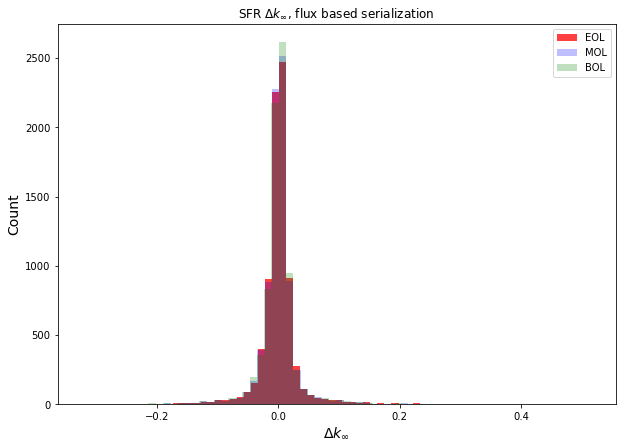

In [51]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=70,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=70,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=70,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("SFR $Δk_{\infty}$, flux based serialization")
plt.legend(loc='upper right')
plt.savefig("SFR_incompleteData_fluxShaped_2.png")
# Show plot
plt.show()


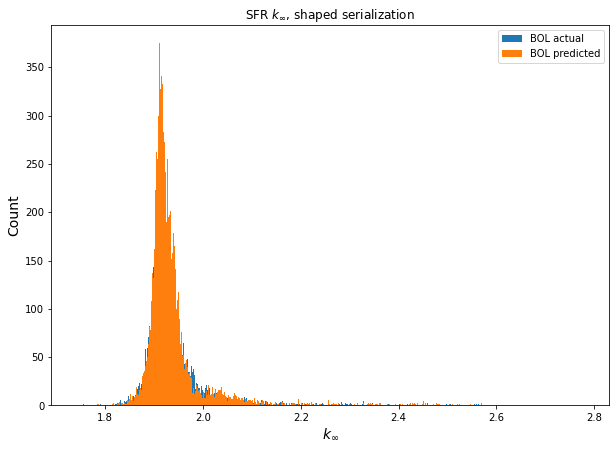

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL actual")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("SFR $k_{\infty}$, shaped serialization")
plt.savefig("kinfPredDist_fluxShaped_narrow_2.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot



In [53]:

print(np.std(a[:,2]))
print(np.std(a[:,1]))
print(np.std(a[:,0]))

0.03901901842931891
0.03961941320533842
0.04023739559658851
